In [ ]:
library(tidyverse)
library(naniar)
library(visdat)
library(ggplot2)
library(lubridate)
library(gridExtra)
library(GGally)
library(corrr)
library(dplyr)
library(car)
library(mgcv)
library(ggfortify)

In [3]:
data = read.csv('data/fatal-police-shootings-data.csv', na.strings=c("","NA"))

### Initial EDA

> DF shape, column names, data-type setting, dropping irrelevant features

In [4]:
dim(data)
names(data)

[1] 7291   19

[1] "id"                      "name"                   
 [3] "date"                    "manner_of_death"        
 [5] "armed"                   "age"                    
 [7] "gender"                  "race"                   
 [9] "city"                    "state"                  
[11] "signs_of_mental_illness" "threat_level"           
[13] "flee"                    "body_camera"            
[15] "longitude"               "latitude"               
[17] "is_geocoding_exact"      "smha_exp_per_capita"    
[19] "smi_prevalance"

In [5]:
head(data)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,smha_exp_per_capita,smi_prevalance
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
1,3,Tim Elliot,2015-01-02,shot,gun,53,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,128.46,0.0472
2,4,Lewis Lee Lembke,2015-01-02,shot,gun,47,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,234.87,0.0483
3,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,124.11,0.0412
4,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,174.98,0.0379
5,9,Michael Rodriguez,2015-01-04,shot,nail gun,39,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,121.90,0.0390
6,11,Kenneth Joe Brown,2015-01-04,shot,gun,18,M,W,Guthrie,OK,False,attack,Not fleeing,False,-97.423,35.877,True,59.29,0.0459


In [6]:
# number of unique values
for (c in names(data)) { print(paste0(c, ": ", length(unique(data[[c]])))) }

[1] "id: 7291"
[1] "name: 6902"
[1] "date: 2485"
[1] "manner_of_death: 2"
[1] "armed: 101"
[1] "age: 81"
[1] "gender: 3"
[1] "race: 7"
[1] "city: 3032"
[1] "state: 51"
[1] "signs_of_mental_illness: 2"
[1] "threat_level: 3"
[1] "flee: 5"
[1] "body_camera: 2"
[1] "longitude: 5783"
[1] "latitude: 5138"
[1] "is_geocoding_exact: 2"
[1] "smha_exp_per_capita: 51"
[1] "smi_prevalance: 47"


In [7]:
# for (i in 1:length(data$armed)){
#     if (data$armed[i] == 'gun') {next}
#     else if (data$armed[i] == 'knife') {next}
#     else if (data$armed[i] == 'vehicle') {next}
#     else if (data$armed[i] == 'unarmed') {next}
#     else if (data$armed[i] == 'undetermined') {next}
#     else {data$armed[i] = 'other'}
# } 

# For some reason, this kept throwing an error for me, so I tried another method
data = data %>% 
  mutate(armed = case_when(
    armed == "gun" ~ "gun",
    armed == "knife" ~ "knife",
    armed == "vehicle" ~ "vehicle",
    armed == "unarmed" ~ "unarmed",
    armed == "undetermined" ~ "undetermined",
    TRUE ~ "other",
  )
)

In [8]:
# Convert features to factor and numeric as appropriate

# CHECK: armed, city, date, longitude, latitude

features_to_drop = c("id", "name", "city")
factor_cols = c("manner_of_death", "armed", "gender", "race", "state", "signs_of_mental_illness", "threat_level", "flee", "body_camera")
numeric_cols = c("age")

In [9]:
data = data[,!(names(data) %in% features_to_drop)]
data <- data %>% 
    mutate(across(.cols=all_of(factor_cols), .fns = as.factor))
data <- data %>% 
    mutate(across(.cols=all_of(numeric_cols), .fns = as.numeric))

In [10]:
# convert date from character to date format
data <- data %>% 
    mutate(across(.cols="date", .fns = as_date))

> Explore feature types, what info they contain

In [11]:
summary(data)

      date                    manner_of_death          armed     
 Min.   :2015-01-02   shot            :6952   gun         :4159  
 1st Qu.:2016-11-08   shot and Tasered: 339   knife       :1051  
 Median :2018-09-04                           other       :1112  
 Mean   :2018-09-08                           unarmed     : 443  
 3rd Qu.:2020-07-12                           undetermined: 262  
 Max.   :2022-04-20                           vehicle     : 264  
                                                                 
      age         gender       race          state      signs_of_mental_illness
 Min.   : 6.00   F   : 330   A   : 105   CA     :1063   False:5715             
 1st Qu.:27.00   M   :6951   B   :1595   TX     : 642   True :1576             
 Median :35.00   NA's:  10   H   :1089   FL     : 461                          
 Mean   :37.15               N   :  91   AZ     : 334                          
 3rd Qu.:45.00               O   :  47   GA     : 272                   

Run Univariate analysis of each feature

In [12]:
attach(data)

[1] "manner_of_death: Unique Count: 2"
[1] ""
[1] "armed: Unique Count: 6"


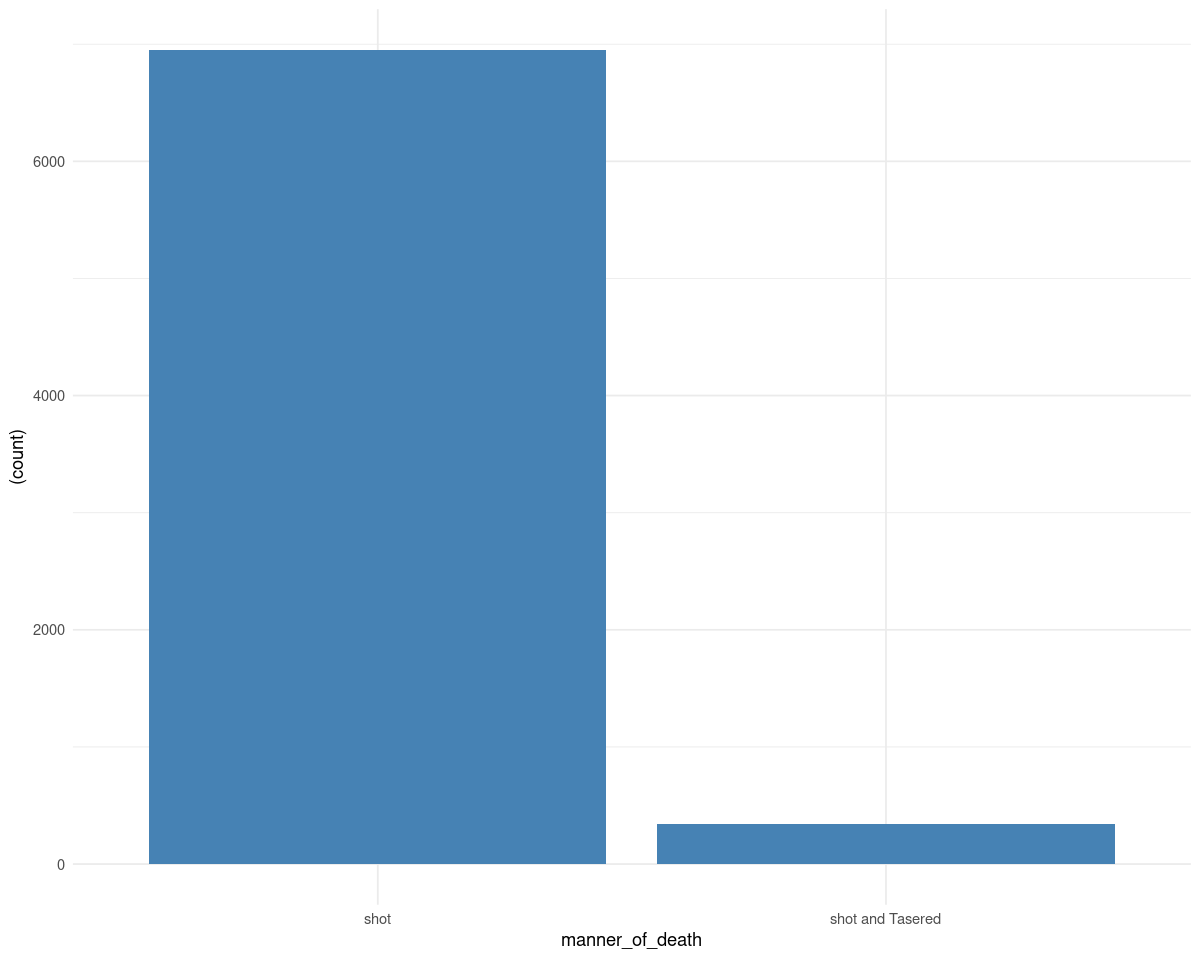

[1] ""
[1] "gender: Unique Count: 3"


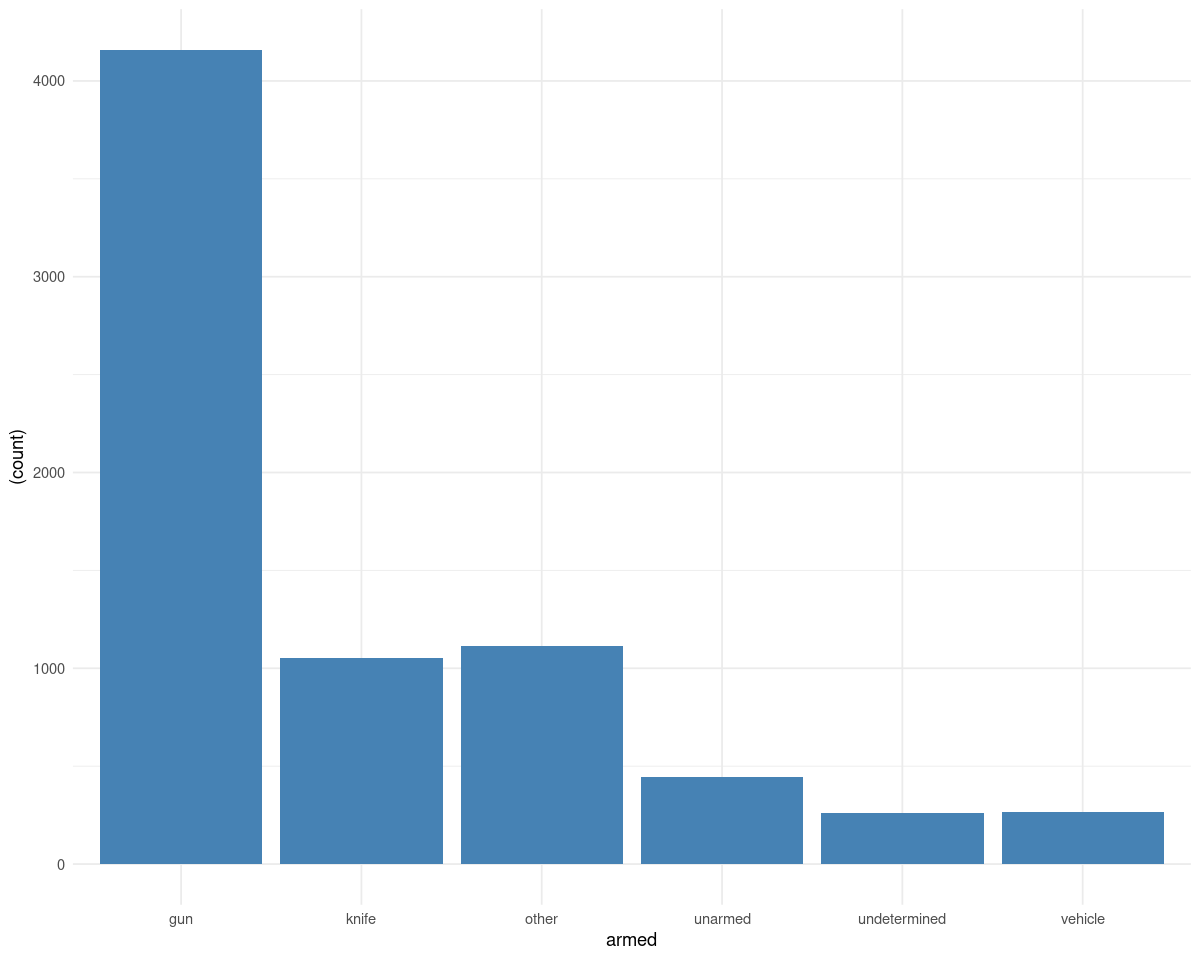

[1] ""
[1] "race: Unique Count: 7"


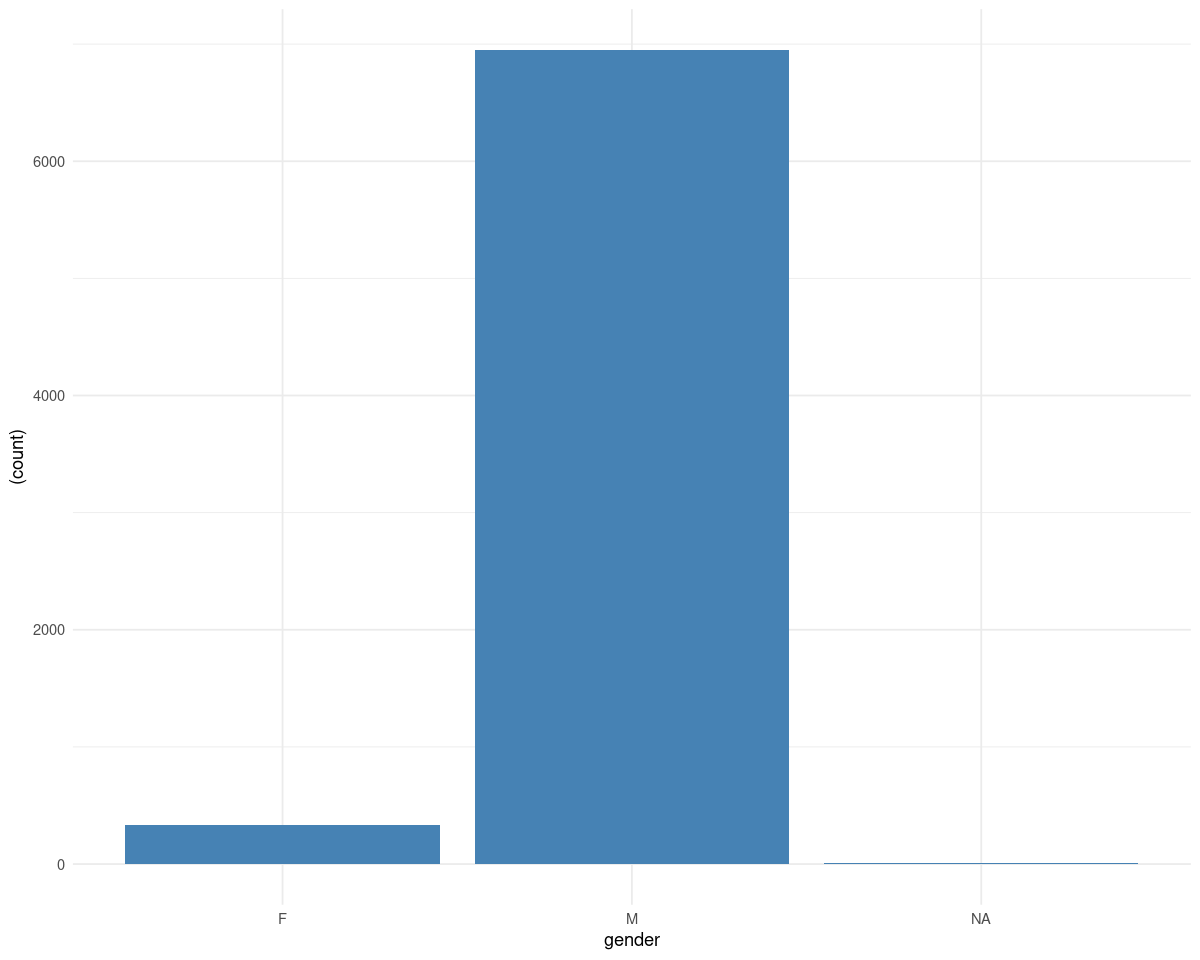

[1] ""
[1] "state: Unique Count: 51"
   Var1 Freq
1    AK   49
2    AL  138
3    AR  102
4    AZ  334
5    CA 1063
6    CO  262
7    CT   22
8    DC   22
9    DE   17
10   FL  461
11   GA  272
12   HI   37
13   IA   45
14   ID   61
15   IL  146
16   IN  137
17   KS   67
18   KY  133
19   LA  150
20   MA   53
21   MD  102
22   ME   30
23   MI  125
24   MN   81
25   MO  191
26   MS   94
27   MT   46
28   NC  204
29   ND   15
30   NE   37
31   NH   20
32   NJ   85
33   NM  156
34   NV  121
35   NY  133
36   OH  199
37   OK  205
38   OR  117
39   PA  150
40   RI    5
41   SC  115
42   SD   24
43   TN  203
44   TX  642
45   UT   85
46   VA  127
47   VT   11
48   WA  198
49   WI  111
50   WV   67
51   WY   21
[1] ""
[1] "signs_of_mental_illness: Unique Count: 2"


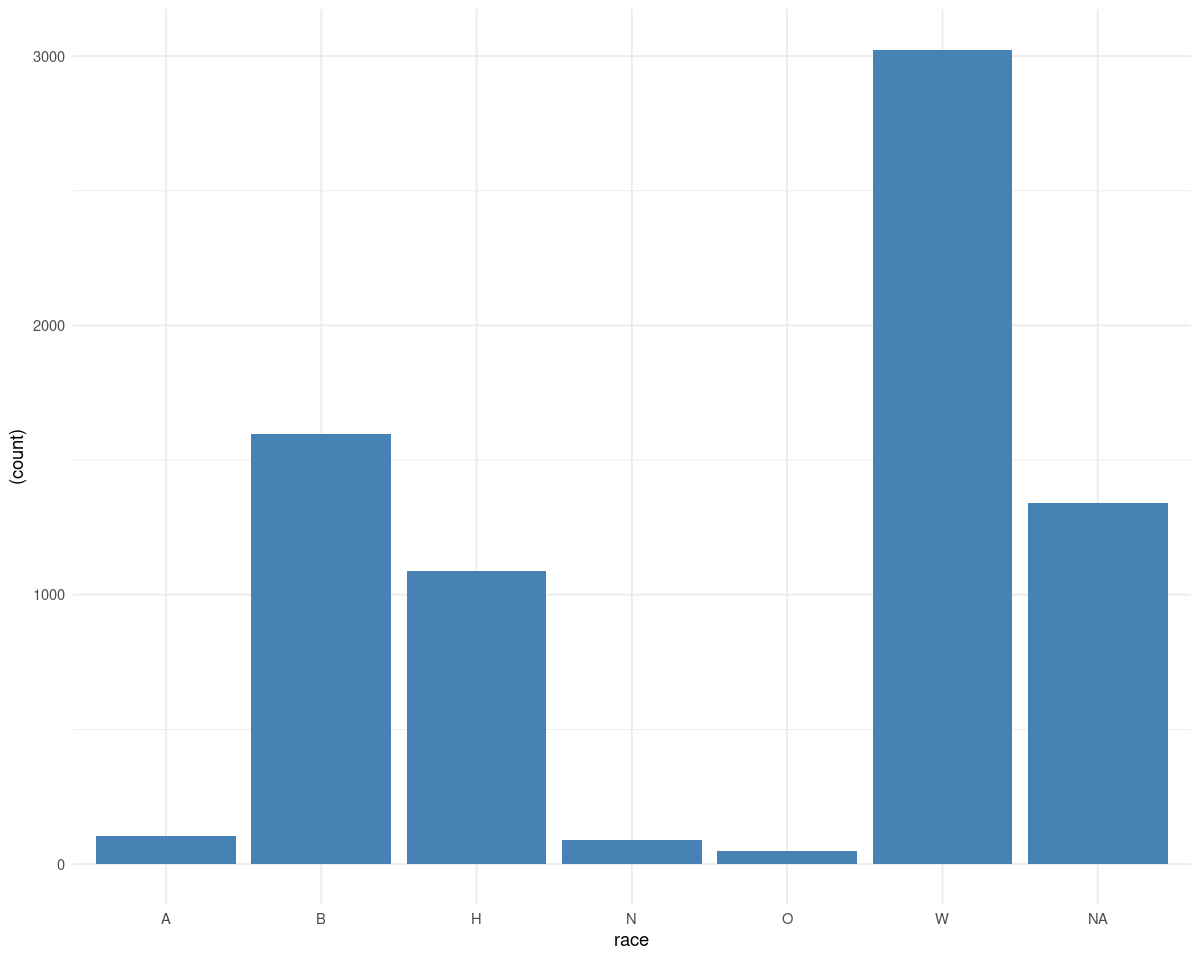

[1] ""
[1] "threat_level: Unique Count: 3"


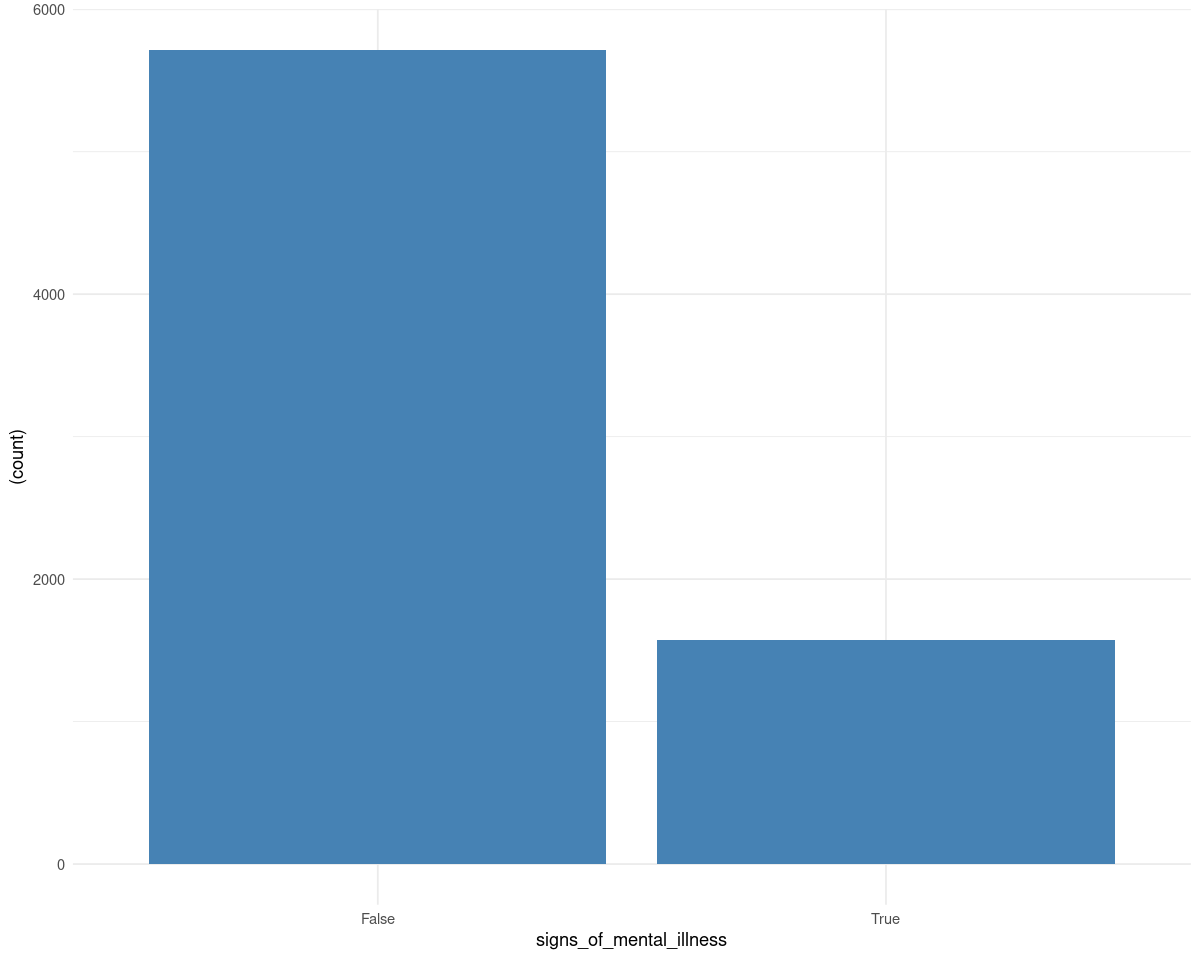

[1] ""
[1] "flee: Unique Count: 5"


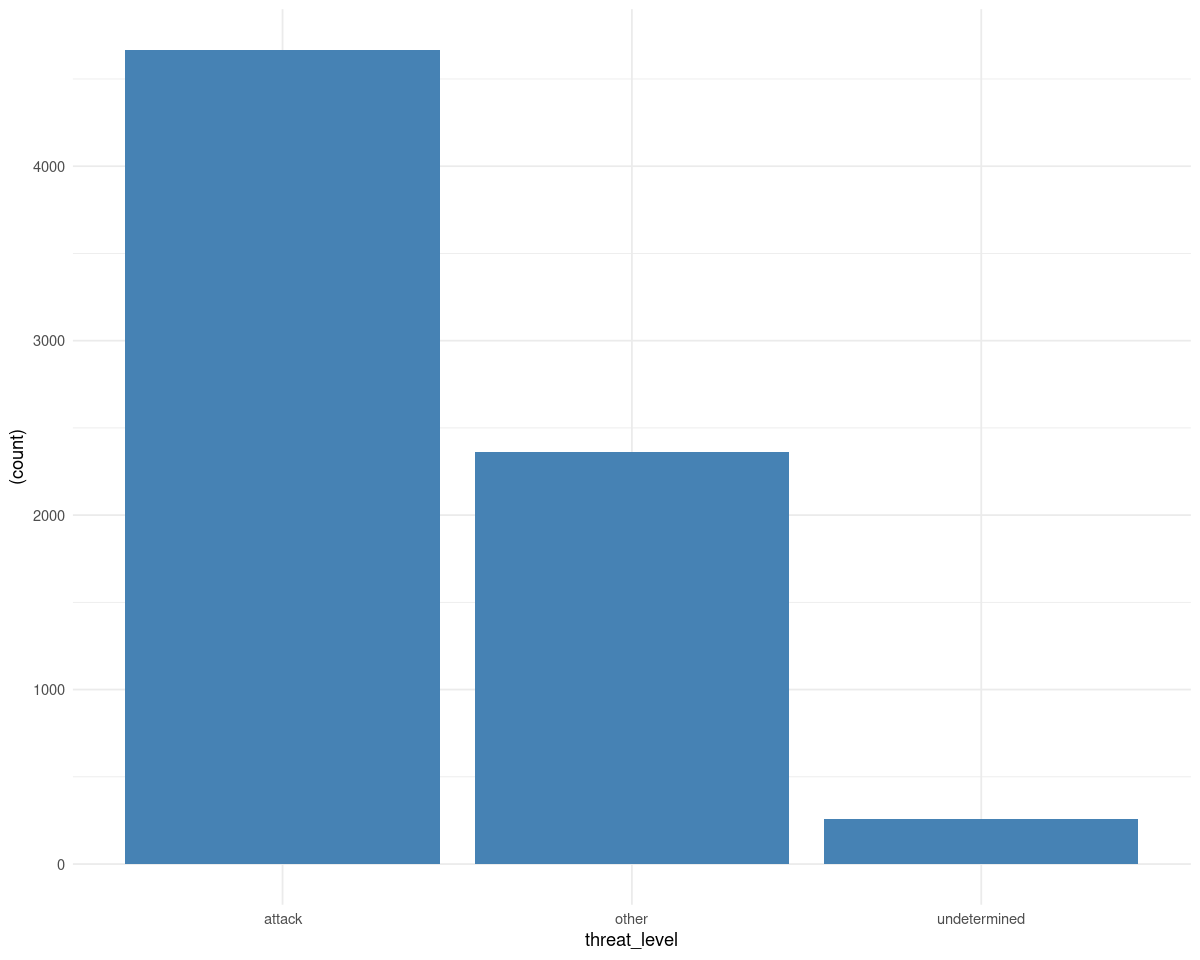

[1] ""
[1] "body_camera: Unique Count: 2"


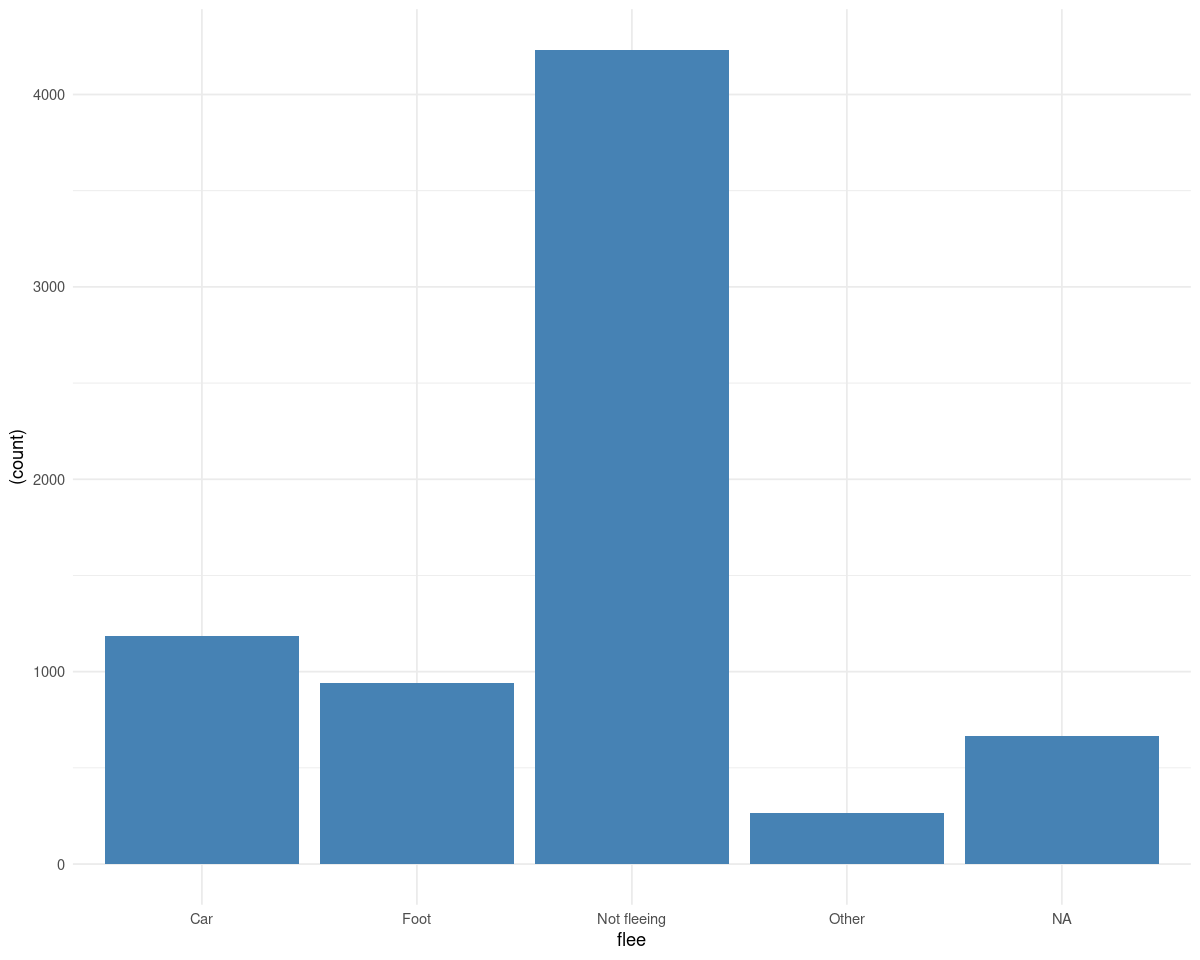

[1] ""


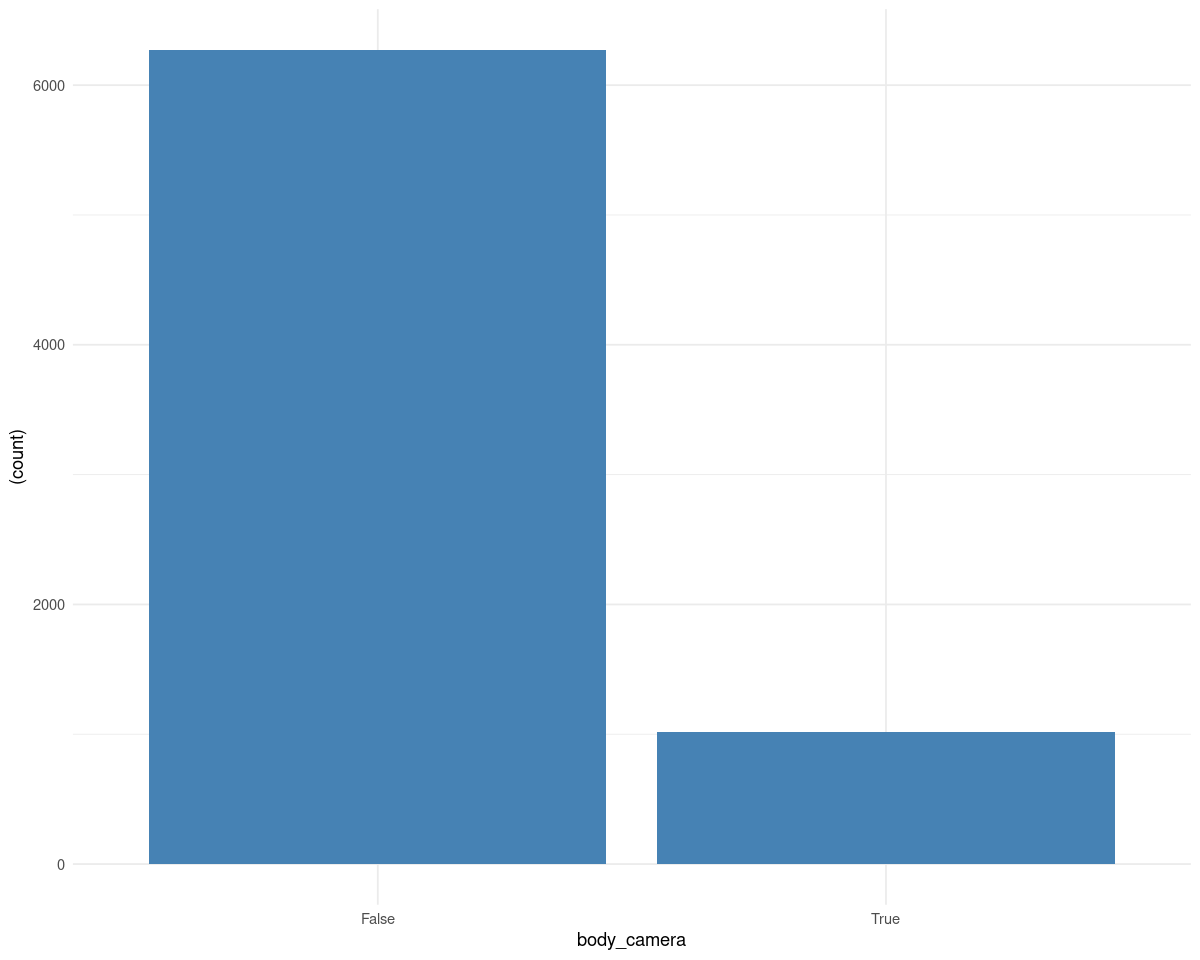

In [29]:
options(repr.plot.width=10, repr.plot.height=8)
for (c in factor_cols) {
    print(paste0(c, ": Unique Count: ", length(unique(data[[c]]))))
    if (length(unique(data[[c]])) < 10) {
        print(ggplot(data=data, aes(x=unlist(data[c]), y=(..count..))) + geom_bar(fill="steelblue") + theme_minimal() + xlab(c))
    } else {
        print(as.data.frame(table(data[c])))
    }
    print("")
}

In [13]:
# print(summary(data$armed))
unique(data$armed)

[1] gun          unarmed      other        knife        vehicle     
[6] undetermined
Levels: gun knife other unarmed undetermined vehicle

Check bivariate vs response

In [14]:
# MI with gender - higher proportion of women classified as MI
MI_gender = table(signs_of_mental_illness, gender)
MI_gender
prop.table(MI_gender, margin = 2)

                       gender
signs_of_mental_illness    F    M
                  False  224 5482
                  True   106 1469

                       gender
signs_of_mental_illness         F         M
                  False 0.6787879 0.7886635
                  True  0.3212121 0.2113365

In [15]:
# MI with race - black lowest at .155, white highest at 0.289
MI_race = table(signs_of_mental_illness, race)
MI_race
prop.table(MI_race, margin = 2)

                       race
signs_of_mental_illness    A    B    H    N    O    W
                  False   78 1347  899   75   37 2150
                  True    27  248  190   16   10  873

                       race
signs_of_mental_illness         A         B         H         N         O
                  False 0.7428571 0.8445141 0.8255280 0.8241758 0.7872340
                  True  0.2571429 0.1554859 0.1744720 0.1758242 0.2127660
                       race
signs_of_mental_illness         W
                  False 0.7112140
                  True  0.2887860

In [33]:
# MI with manner_of_death - higher shot and tasered
MI_MoD= table(signs_of_mental_illness, manner_of_death)
MI_MoD
prop.table(MI_MoD, margin = 2)

                       manner_of_death
signs_of_mental_illness shot shot and Tasered
                  False 5487              228
                  True  1465              111

                       manner_of_death
signs_of_mental_illness      shot shot and Tasered
                  False 0.7892693        0.6725664
                  True  0.2107307        0.3274336

In [34]:
# MI with state - KY lowest at 0.09, NH and VT highest at 0.45 (though very few cases)
MI_state = table(signs_of_mental_illness, state)
MI_state
prop.table(MI_state, margin = 2)

                       state
signs_of_mental_illness  AK  AL  AR  AZ  CA  CO  CT  DC  DE  FL  GA  HI  IA  ID
                  False  42 108  86 276 837 229  16  19  13 339 221  31  36  53
                  True    7  30  16  58 226  33   6   3   4 122  51   6   9   8
                       state
signs_of_mental_illness  IL  IN  KS  KY  LA  MA  MD  ME  MI  MN  MO  MS  MT  NC
                  False 122 103  52 121 115  36  74  27  93  58 161  80  41 160
                  True   24  34  15  12  35  17  28   3  32  23  30  14   5  44
                       state
signs_of_mental_illness  ND  NE  NH  NJ  NM  NV  NY  OH  OK  OR  PA  RI  SC  SD
                  False  12  28  11  66 134  88  86 147 162  80 111   4  93  17
                  True    3   9   9  19  22  33  47  52  43  37  39   1  22   7
                       state
signs_of_mental_illness  TN  TX  UT  VA  VT  WA  WI  WV  WY
                  False 158 517  65  94   6 136  82  54  15
                  True   45 125  20  33   5 

                       state
signs_of_mental_illness         AK         AL         AR         AZ         CA
                  False 0.85714286 0.78260870 0.84313725 0.82634731 0.78739417
                  True  0.14285714 0.21739130 0.15686275 0.17365269 0.21260583
                       state
signs_of_mental_illness         CO         CT         DC         DE         FL
                  False 0.87404580 0.72727273 0.86363636 0.76470588 0.73535792
                  True  0.12595420 0.27272727 0.13636364 0.23529412 0.26464208
                       state
signs_of_mental_illness         GA         HI         IA         ID         IL
                  False 0.81250000 0.83783784 0.80000000 0.86885246 0.83561644
                  True  0.18750000 0.16216216 0.20000000 0.13114754 0.16438356
                       state
signs_of_mental_illness         IN         KS         KY         LA         MA
                  False 0.75182482 0.77611940 0.90977444 0.76666667 0.67924528
               

In [45]:
# MI with threat_level - undetermined much lower than others, prob not helpful
MI_threat = table(signs_of_mental_illness, threat_level)
MI_threat
prop.table(MI_threat, margin = 2)

                       threat_level
signs_of_mental_illness attack other undetermined
                  False   3691  1798          226
                  True     976   566           34

                       threat_level
signs_of_mental_illness    attack     other undetermined
                  False 0.7908721 0.7605753    0.8692308
                  True  0.2091279 0.2394247    0.1307692

In [46]:
# MI with flee - not fleeing is far higher than the other three options
MI_flee = table(signs_of_mental_illness, flee)
MI_flee
prop.table(MI_flee, margin = 2)

                       flee
signs_of_mental_illness  Car Foot Not fleeing Other
                  False 1082  833        2987   244
                  True   101  110        1245    23

                       flee
signs_of_mental_illness        Car       Foot Not fleeing      Other
                  False 0.91462384 0.88335101  0.70581285 0.91385768
                  True  0.08537616 0.11664899  0.29418715 0.08614232

In [47]:
# MI with body_camera - higher with body camera
MI_body_camera = table(signs_of_mental_illness, body_camera)
MI_body_camera
prop.table(MI_body_camera, margin = 2)

                       body_camera
signs_of_mental_illness False True
                  False  4965  750
                  True   1307  269

                       body_camera
signs_of_mental_illness     False      True
                  False 0.7916135 0.7360157
                  True  0.2083865 0.2639843

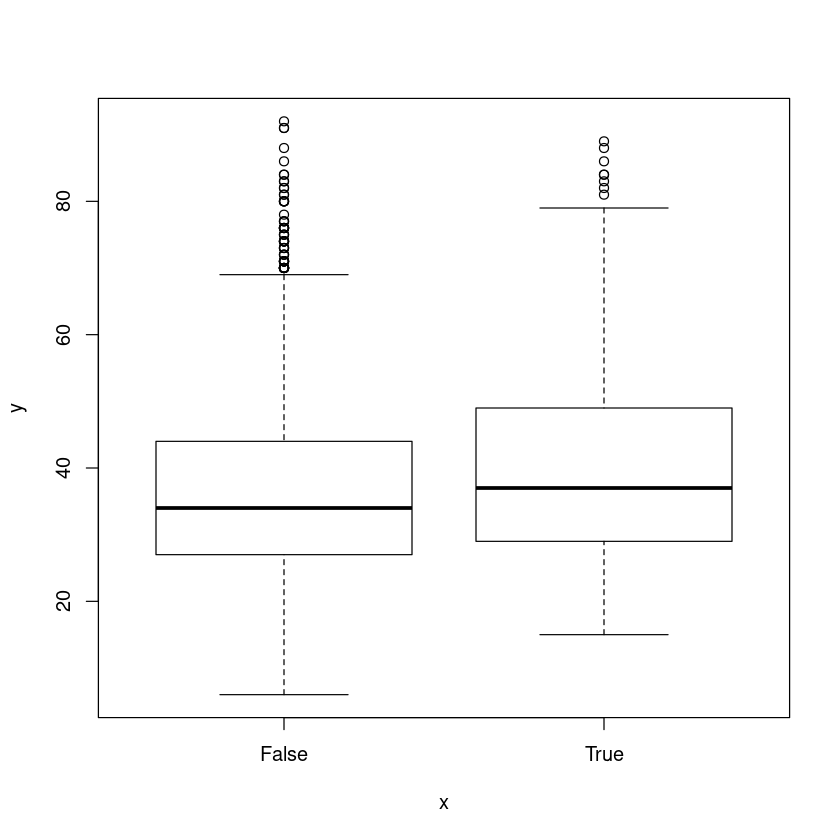

In [16]:
# MI with age - mean age a bit higher among MI than not MI
plot(signs_of_mental_illness, age)

In [17]:
plot(x=population,y=count,xlab="Population",ylab="Count")

Warning message in data.matrix(x):
“NAs introduced by coercion”


ERROR: Error in plot.default(...): formal argument "xlab" matched by multiple actual arguments


In [39]:
# MI with year - this is interesting, steadily going down YoY, then big drop off
# from 2020 to 2021
MI_year = table(signs_of_mental_illness, year(date))
MI_year
prop.table(MI_year, margin = 2)

                       
signs_of_mental_illness 2015 2016 2017 2018 2019 2020 2021 2022
                  False  734  710  743  764  783  802  907  272
                  True   260  248  238  221  216  218  147   28

                       
signs_of_mental_illness       2015       2016       2017       2018       2019
                  False 0.73843058 0.74112735 0.75739042 0.77563452 0.78378378
                  True  0.26156942 0.25887265 0.24260958 0.22436548 0.21621622
                       
signs_of_mental_illness       2020       2021       2022
                  False 0.78627451 0.86053131 0.90666667
                  True  0.21372549 0.13946869 0.09333333

In [40]:
# MI with month - proportions relatively constant across months
MI_month = table(signs_of_mental_illness, month(date))
MI_month
prop.table(MI_month, margin = 2)

                       
signs_of_mental_illness   1   2   3   4   5   6   7   8   9  10  11  12
                  False 525 535 560 482 444 470 442 462 387 485 450 473
                  True  150 137 168 133 126 123 138 140 116 119 104 122

                       
signs_of_mental_illness         1         2         3         4         5
                  False 0.7777778 0.7961310 0.7692308 0.7837398 0.7789474
                  True  0.2222222 0.2038690 0.2307692 0.2162602 0.2210526
                       
signs_of_mental_illness         6         7         8         9        10
                  False 0.7925801 0.7620690 0.7674419 0.7693837 0.8029801
                  True  0.2074199 0.2379310 0.2325581 0.2306163 0.1970199
                       
signs_of_mental_illness        11        12
                  False 0.8122744 0.7949580
                  True  0.1877256 0.2050420

In [41]:
# MI with day - not much of a pattern, though seemingly lower around end of month
MI_day = table(signs_of_mental_illness, day(date))
MI_day
prop.table(MI_day, margin = 2)

                       
signs_of_mental_illness   1   2   3   4   5   6   7   8   9  10  11  12  13  14
                  False 196 148 181 182 221 194 193 173 211 187 207 176 183 197
                  True   49  59  57  67  60  61  56  50  46  57  48  51  45  62
                       
signs_of_mental_illness  15  16  17  18  19  20  21  22  23  24  25  26  27  28
                  False 179 205 201 186 183 174 164 191 201 175 166 184 208 185
                  True   52  56  46  45  59  53  64  39  52  50  59  50  53  38
                       
signs_of_mental_illness  29  30  31
                  False 183 162 119
                  True   39  25  28

                       
signs_of_mental_illness         1         2         3         4         5
                  False 0.8000000 0.7149758 0.7605042 0.7309237 0.7864769
                  True  0.2000000 0.2850242 0.2394958 0.2690763 0.2135231
                       
signs_of_mental_illness         6         7         8         9        10
                  False 0.7607843 0.7751004 0.7757848 0.8210117 0.7663934
                  True  0.2392157 0.2248996 0.2242152 0.1789883 0.2336066
                       
signs_of_mental_illness        11        12        13        14        15
                  False 0.8117647 0.7753304 0.8026316 0.7606178 0.7748918
                  True  0.1882353 0.2246696 0.1973684 0.2393822 0.2251082
                       
signs_of_mental_illness        16        17        18        19        20
                  False 0.7854406 0.8137652 0.8051948 0.7561983 0.7665198
                  True  0.2145594 0.1862348 0.1948052 0.2438017 0.2334802
                

In [42]:
# MI with day of week - not much of a pattern
MI_day_of_week = table(signs_of_mental_illness, wday(date, label=TRUE))
MI_day_of_week
prop.table(MI_day_of_week, margin = 2)

                       
signs_of_mental_illness Sun Mon Tue Wed Thu Fri Sat
                  False 758 775 870 885 852 813 762
                  True  242 218 238 215 235 228 200

                       
signs_of_mental_illness       Sun       Mon       Tue       Wed       Thu
                  False 0.7580000 0.7804632 0.7851986 0.8045455 0.7838086
                  True  0.2420000 0.2195368 0.2148014 0.1954545 0.2161914
                       
signs_of_mental_illness       Fri       Sat
                  False 0.7809798 0.7920998
                  True  0.2190202 0.2079002

In [49]:
# MI with armed - knife and other higher than the rest, vehicle very low
MI_armed = table(signs_of_mental_illness, armed)
MI_armed
prop.table(MI_armed, margin = 2)

                       armed
signs_of_mental_illness  gun knife other unarmed undetermined vehicle
                  False 3378   690   803     358          235     251
                  True   781   361   309      85           27      13

                       armed
signs_of_mental_illness        gun      knife      other    unarmed
                  False 0.81221447 0.65651760 0.72212230 0.80812641
                  True  0.18778553 0.34348240 0.27787770 0.19187359
                       armed
signs_of_mental_illness undetermined    vehicle
                  False   0.89694656 0.95075758
                  True    0.10305344 0.04924242

In [44]:
MI_year_race = data %>% group_by(year(date), race, signs_of_mental_illness) %>% count()

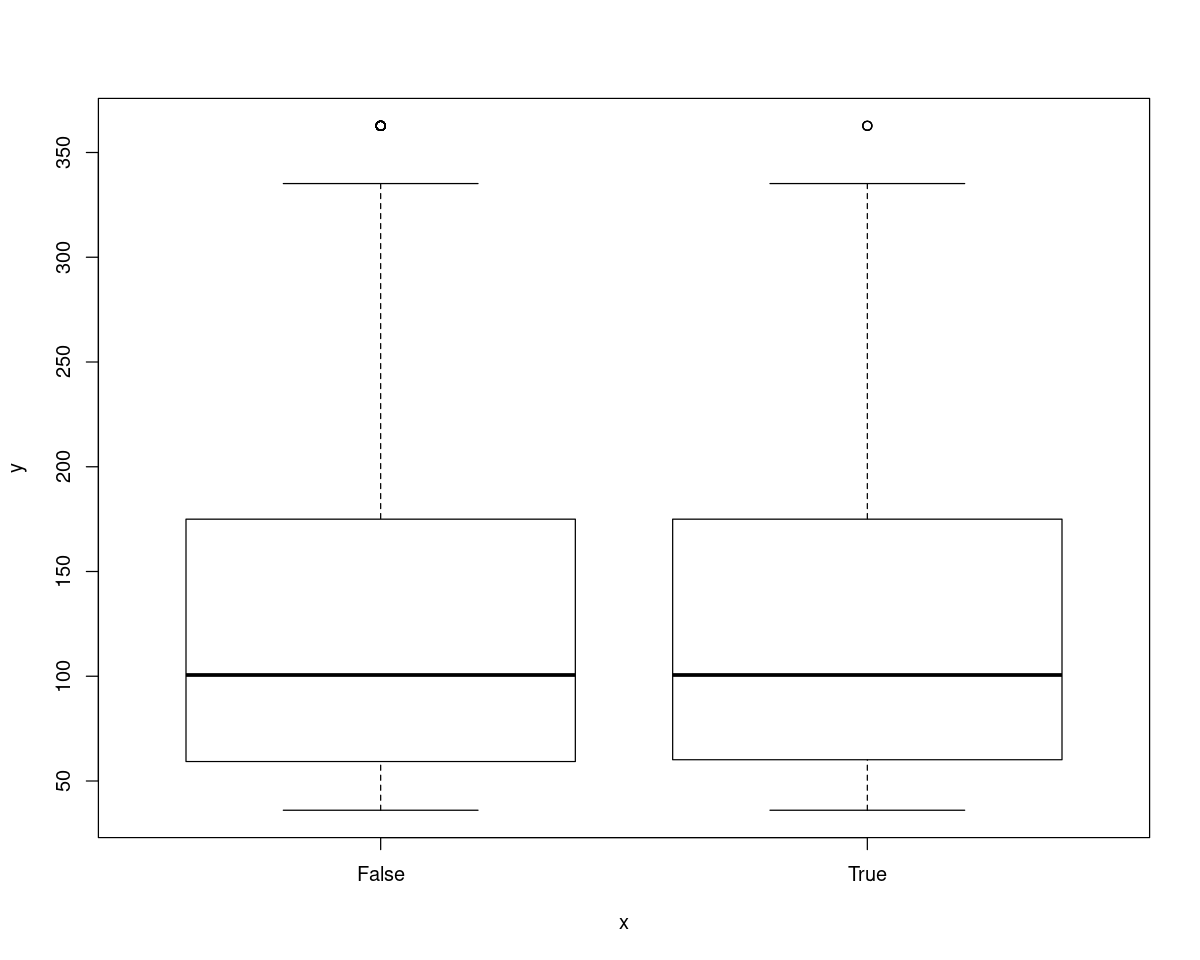

In [51]:
# MI with smha_exp_per_capita - No difference
plot(signs_of_mental_illness, smha_exp_per_capita)

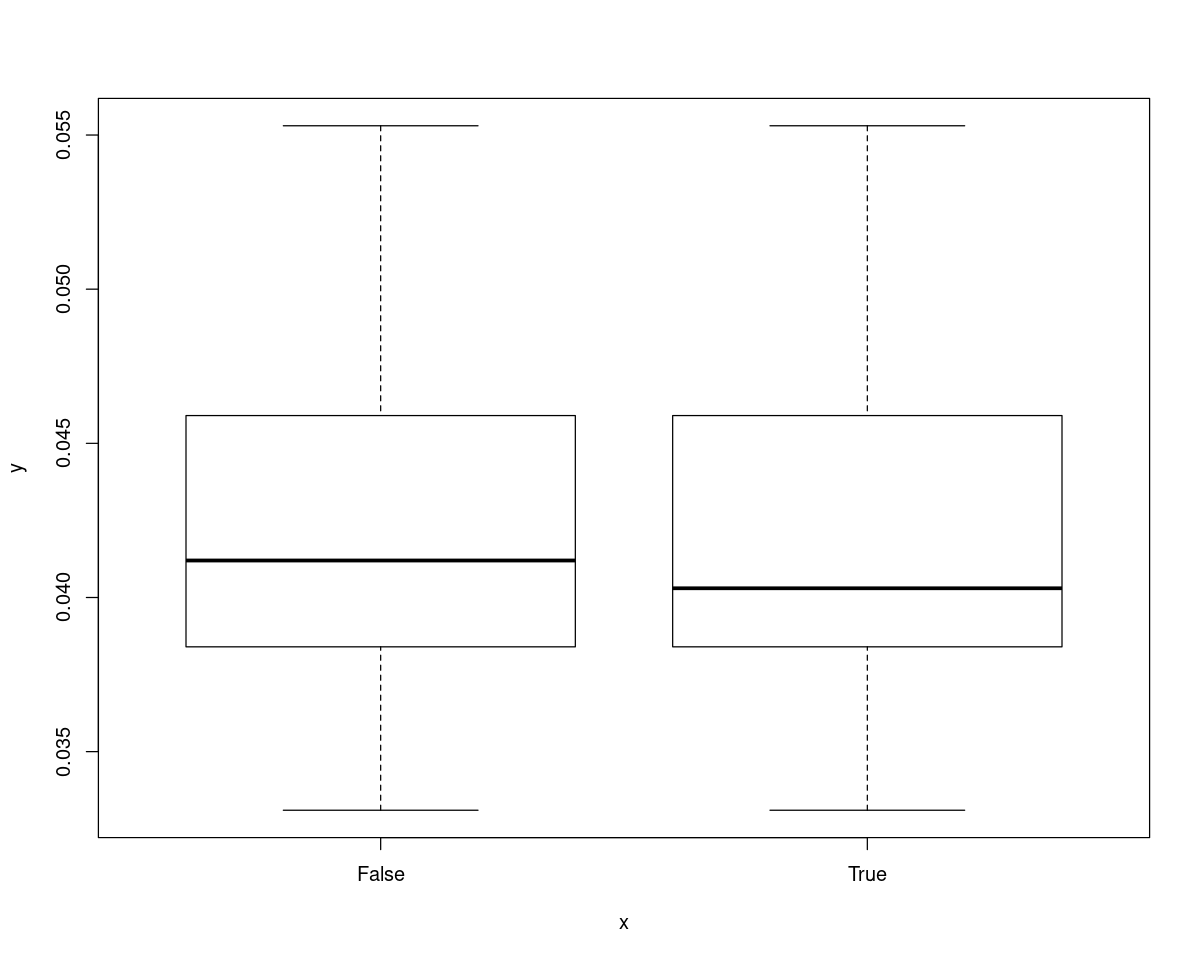

In [52]:
# MI with smi_prevalance - No difference
plot(signs_of_mental_illness, smi_prevalance)

Check GGPairs

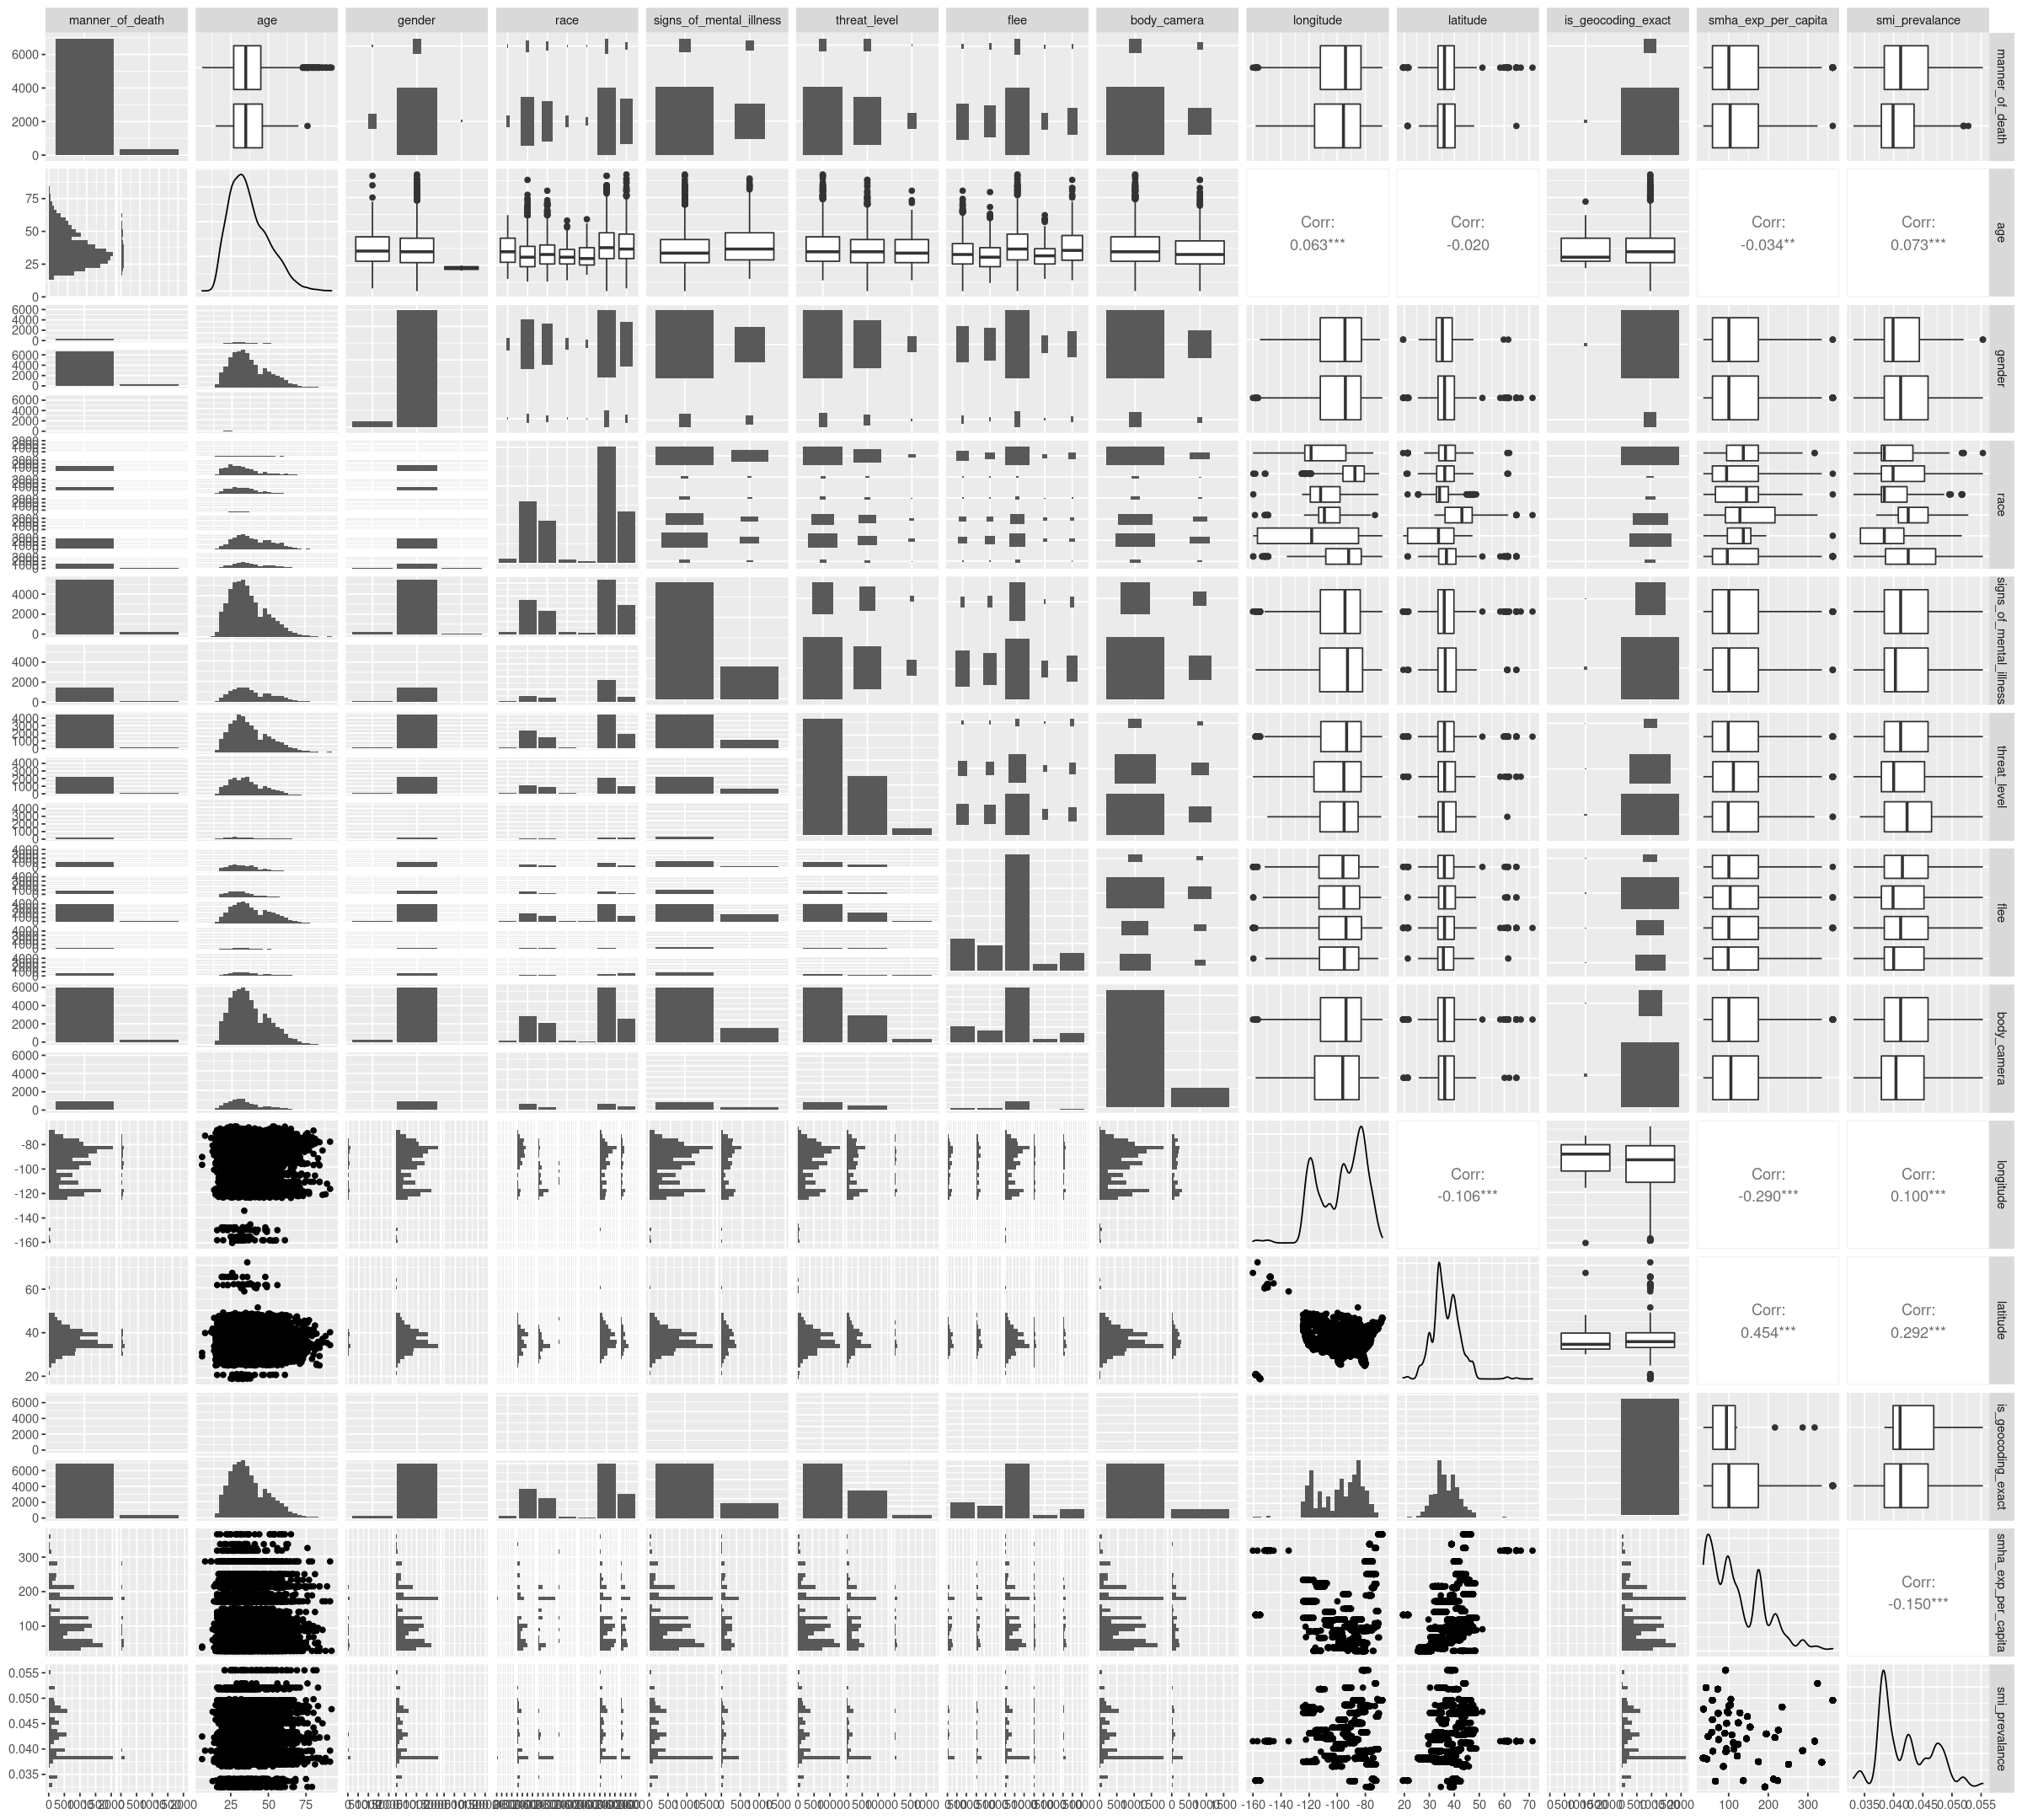

In [21]:
options(repr.plot.width=20, repr.plot.height=18)
ggpairs(data[,!(names(data) %in% c("date", "armed", "state"))])

#### Year-wise counts
2015:994<br>2016:958<br>2017:981<br>2018:985<br>2019:999<br>2020:1020<br>2021:1054<br>2022:300

### Missingness patterns

Check missing data frequency for each column

In [131]:
# Percent missing values per column
as.data.frame((colMeans(is.na(data)))*100)

,(colMeans(is.na(data))) * 100
,<dbl>
date,0.0000000
manner_of_death,0.0000000
armed,2.8665478
age,5.7742422
gender,0.1371554
race,18.3925387
state,0.0000000
signs_of_mental_illness,0.0000000
threat_level,0.0000000


Check patterns in data missingness

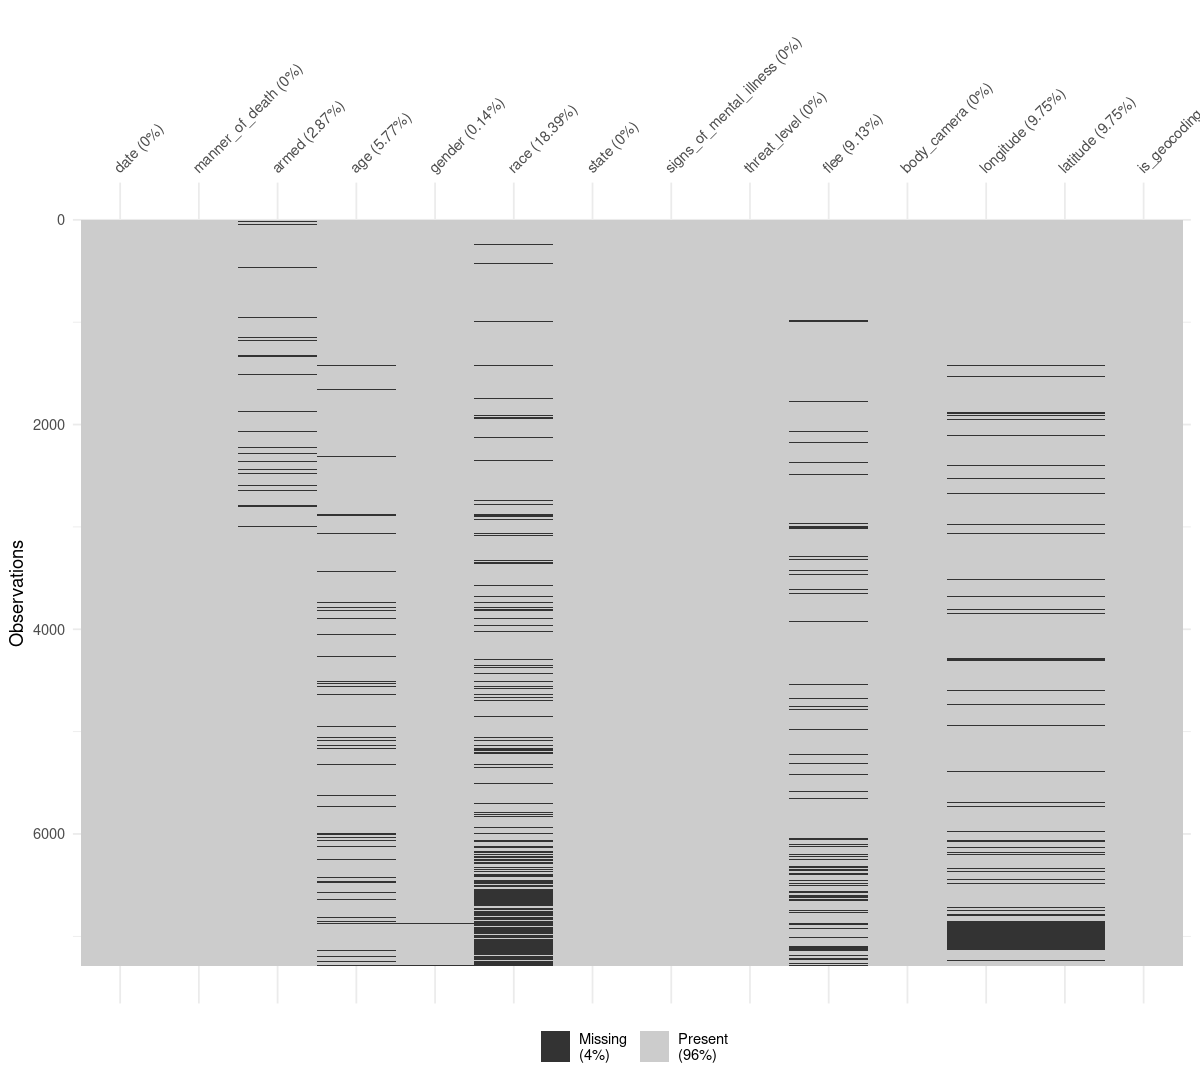

In [135]:
options(repr.plot.width=10, repr.plot.height=9)
vis_miss(data)

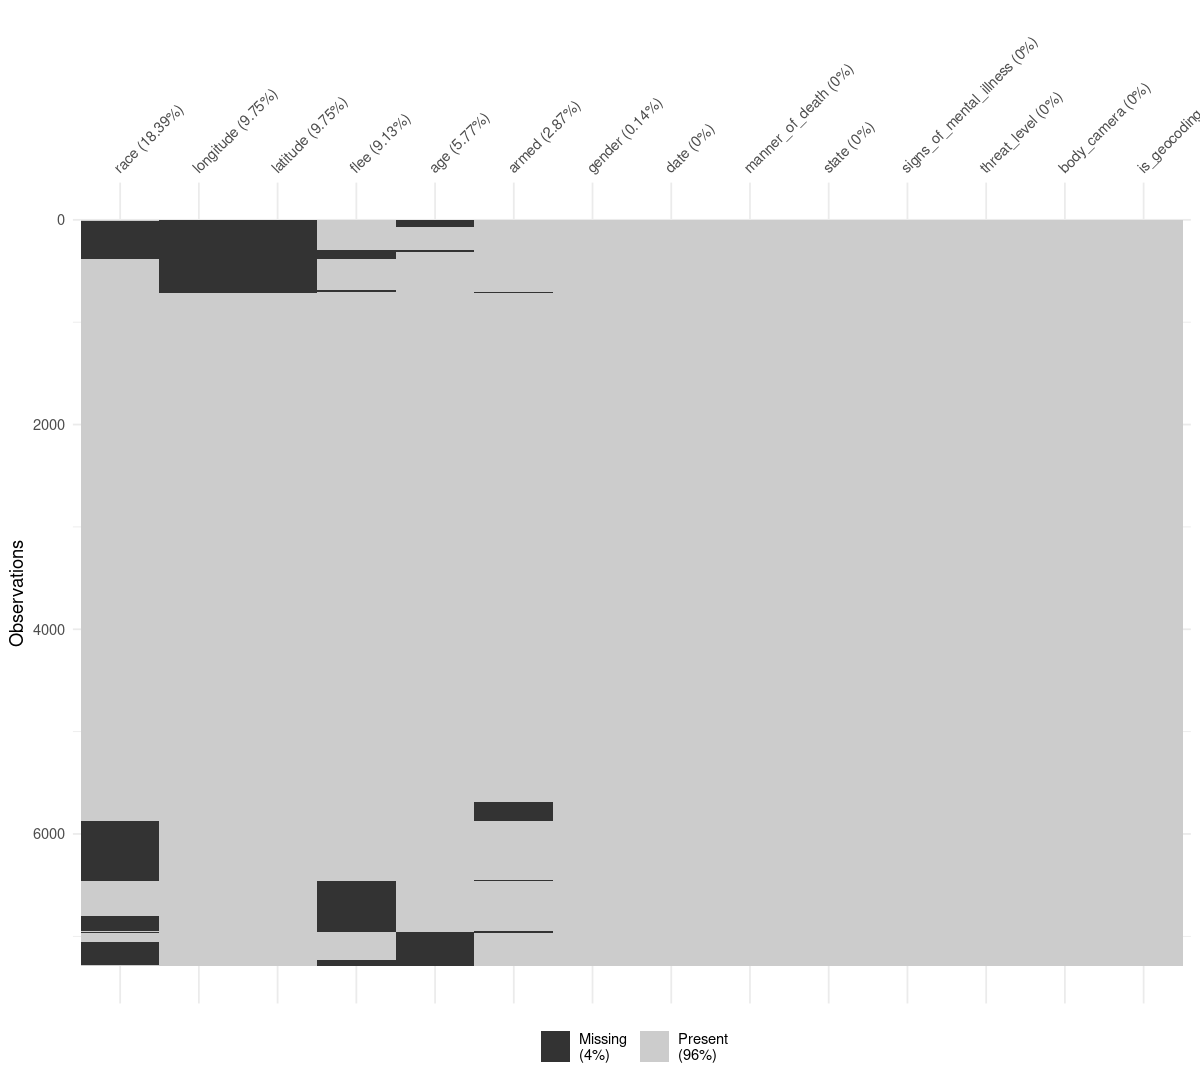

In [136]:
vis_miss(data, cluster = TRUE, sort_miss = TRUE)

#### To add in EDA:
1. Rolling average (over time) of proportion of victims showing evidence of mental illness - overall and by race
2. The proportion of people afflicted in the general population vs in this dataset - possibly break down by state

In [22]:
head(data)

,date,manner_of_death,armed,age,gender,race,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,smha_exp_per_capita,smi_prevalance,yr
,<date>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,2015-01-02,shot,gun,53,M,A,WA,True,attack,Not fleeing,False,-123.122,47.247,True,128.46,0.0472,2015
2,2015-01-02,shot,gun,47,M,W,OR,False,attack,Not fleeing,False,-122.892,45.487,True,234.87,0.0483,2015
3,2015-01-03,shot and Tasered,unarmed,23,M,H,KS,False,other,Not fleeing,False,-97.281,37.695,True,124.11,0.0412,2015
4,2015-01-04,shot,other,32,M,W,CA,True,attack,Not fleeing,False,-122.422,37.763,True,174.98,0.0379,2015
5,2015-01-04,shot,other,39,M,H,CO,False,attack,Not fleeing,False,-104.692,40.384,True,121.90,0.0390,2015
6,2015-01-04,shot,gun,18,M,W,OK,False,attack,Not fleeing,False,-97.423,35.877,True,59.29,0.0459,2015


In [28]:
# The proportion of fatal shootings where SMI is True
# head(data)
data = data %>% mutate(yr = year(date))
smi_data = data %>% filter(signs_of_mental_illness == 'True')
total_counts_by_state_year = aggregate(data$signs_of_mental_illness, by=list(data$state, data$yr), FUN=length)
smi_counts_by_state_year = aggregate(smi_data$signs_of_mental_illness, by=list(smi_data$state, smi_data$yr), FUN=length)

props_by_state_year = merge(total_counts_by_state_year, smi_counts_by_state_year, by=c("Group.1", "Group.2"), all = TRUE)
props_by_state_year$x.y[is.na(props_by_state_year$x.y)] <- 0
props_by_state_year$per = props_by_state_year$x.y / props_by_state_year$x.x

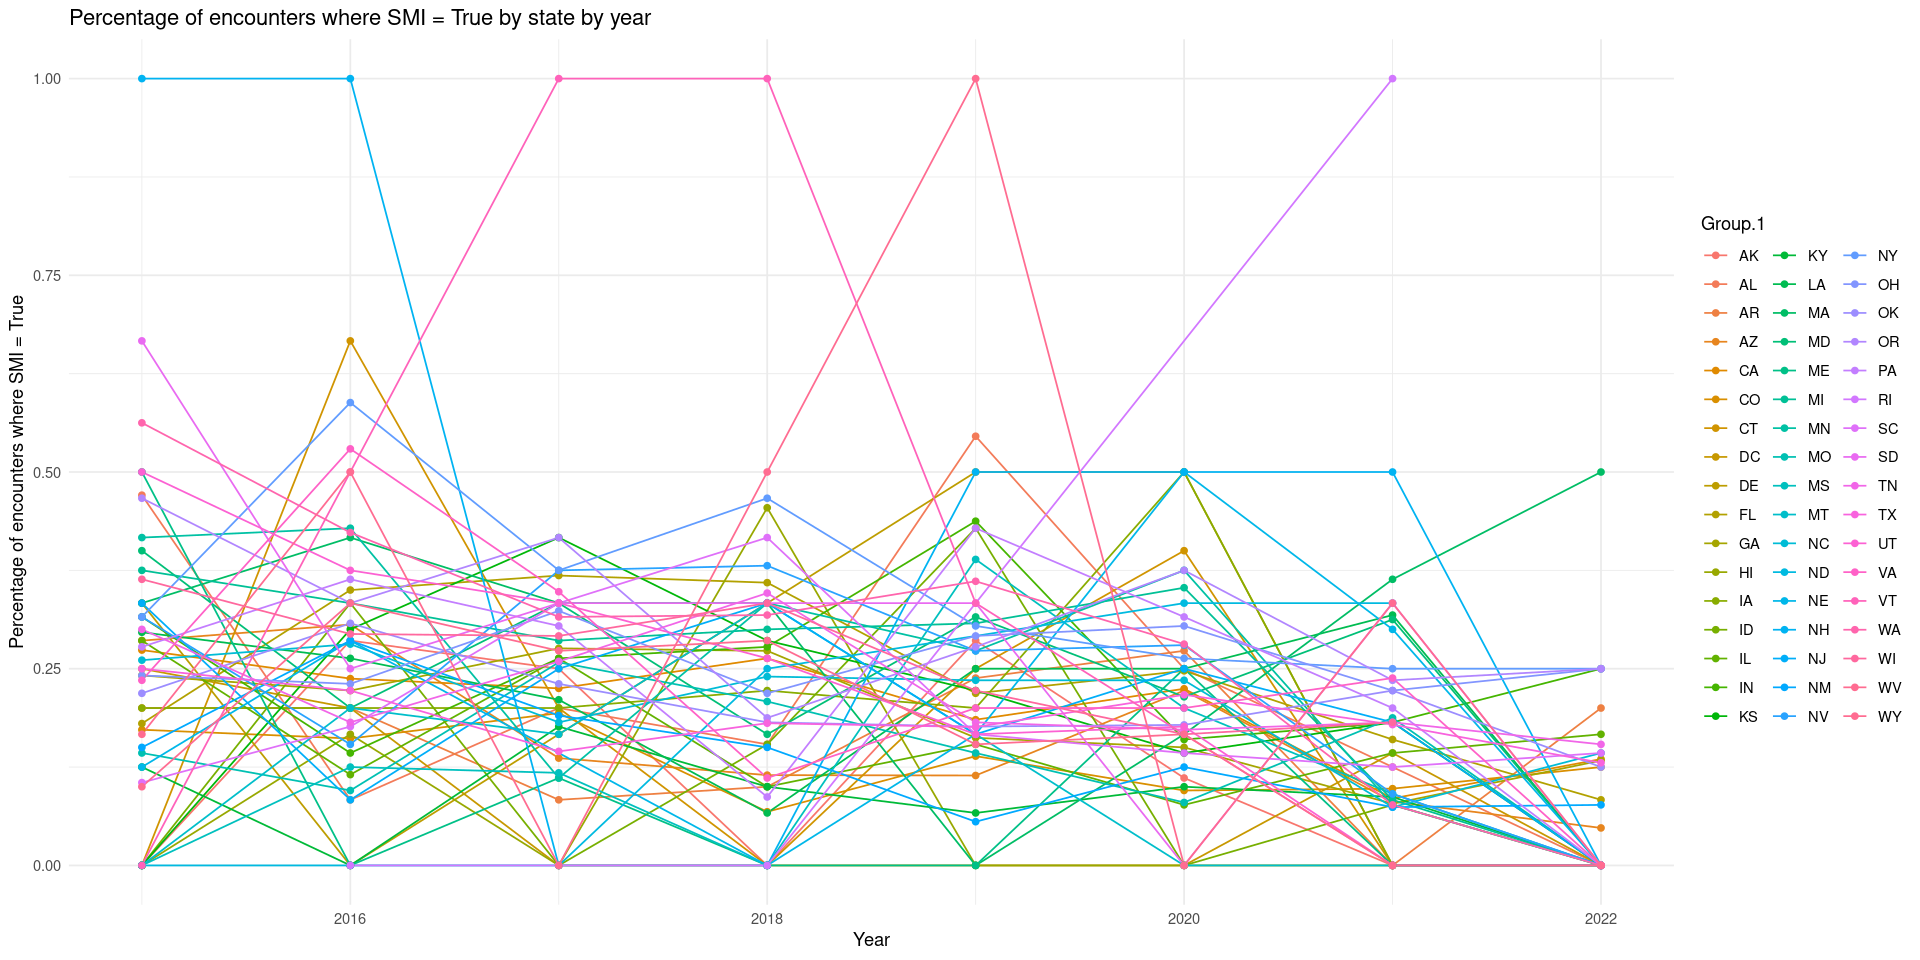

In [37]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(data=props_by_state_year,
       aes(x=Group.2, y=per, colour=	Group.1)) +
       geom_line() + geom_point() + theme_minimal() +
       xlab("Year") +
       ylab("Percentage of encounters where SMI = True") +
       ggtitle("Percentage of encounters where SMI = True by state by year")

In [44]:
head(props_by_state_year[order(-props_by_state_year$per),])

,Group.1,Group.2,x.x,x.y,per
,<fct>,<dbl>,<int>,<dbl>,<dbl>
234,NH,2015,3,3,1
235,NH,2016,2,2,1
309,RI,2021,1,1,1
360,VT,2017,1,1,1
361,VT,2018,2,2,1
391,WY,2019,1,1,1


In [47]:
# The proportion of fatal shootings where SMI is True

# Race -> Combine A/N/O/NA under O?
data = data %>% 
  mutate(race = case_when(
    race == "W" ~ "W",
    race == "B" ~ "B",
    race == "H" ~ "H",
    TRUE ~ "O",
  )
)
data$race = as.factor(data$race)
summary(data$race)

total_counts_by_race_year = aggregate(data$signs_of_mental_illness, by=list(data$race, data$yr), FUN=length)
smi_counts_by_race_year = aggregate(smi_data$signs_of_mental_illness, by=list(smi_data$race, smi_data$yr), FUN=length)

props_by_race_year = merge(total_counts_by_race_year, smi_counts_by_race_year, by=c("Group.1", "Group.2"), all = TRUE)
props_by_race_year$x.y[is.na(props_by_race_year$x.y)] <- 0
props_by_race_year$per = props_by_race_year$x.y / props_by_race_year$x.x

B    H    O    W 
1595 1089 1584 3023

In [55]:
# Race has been recorded for only 2 shootings in 2022
props_by_race_year = props_by_race_year %>% filter(Group.2 != 2022)

Warning message:
“Removed 12 row(s) containing missing values (geom_path).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”


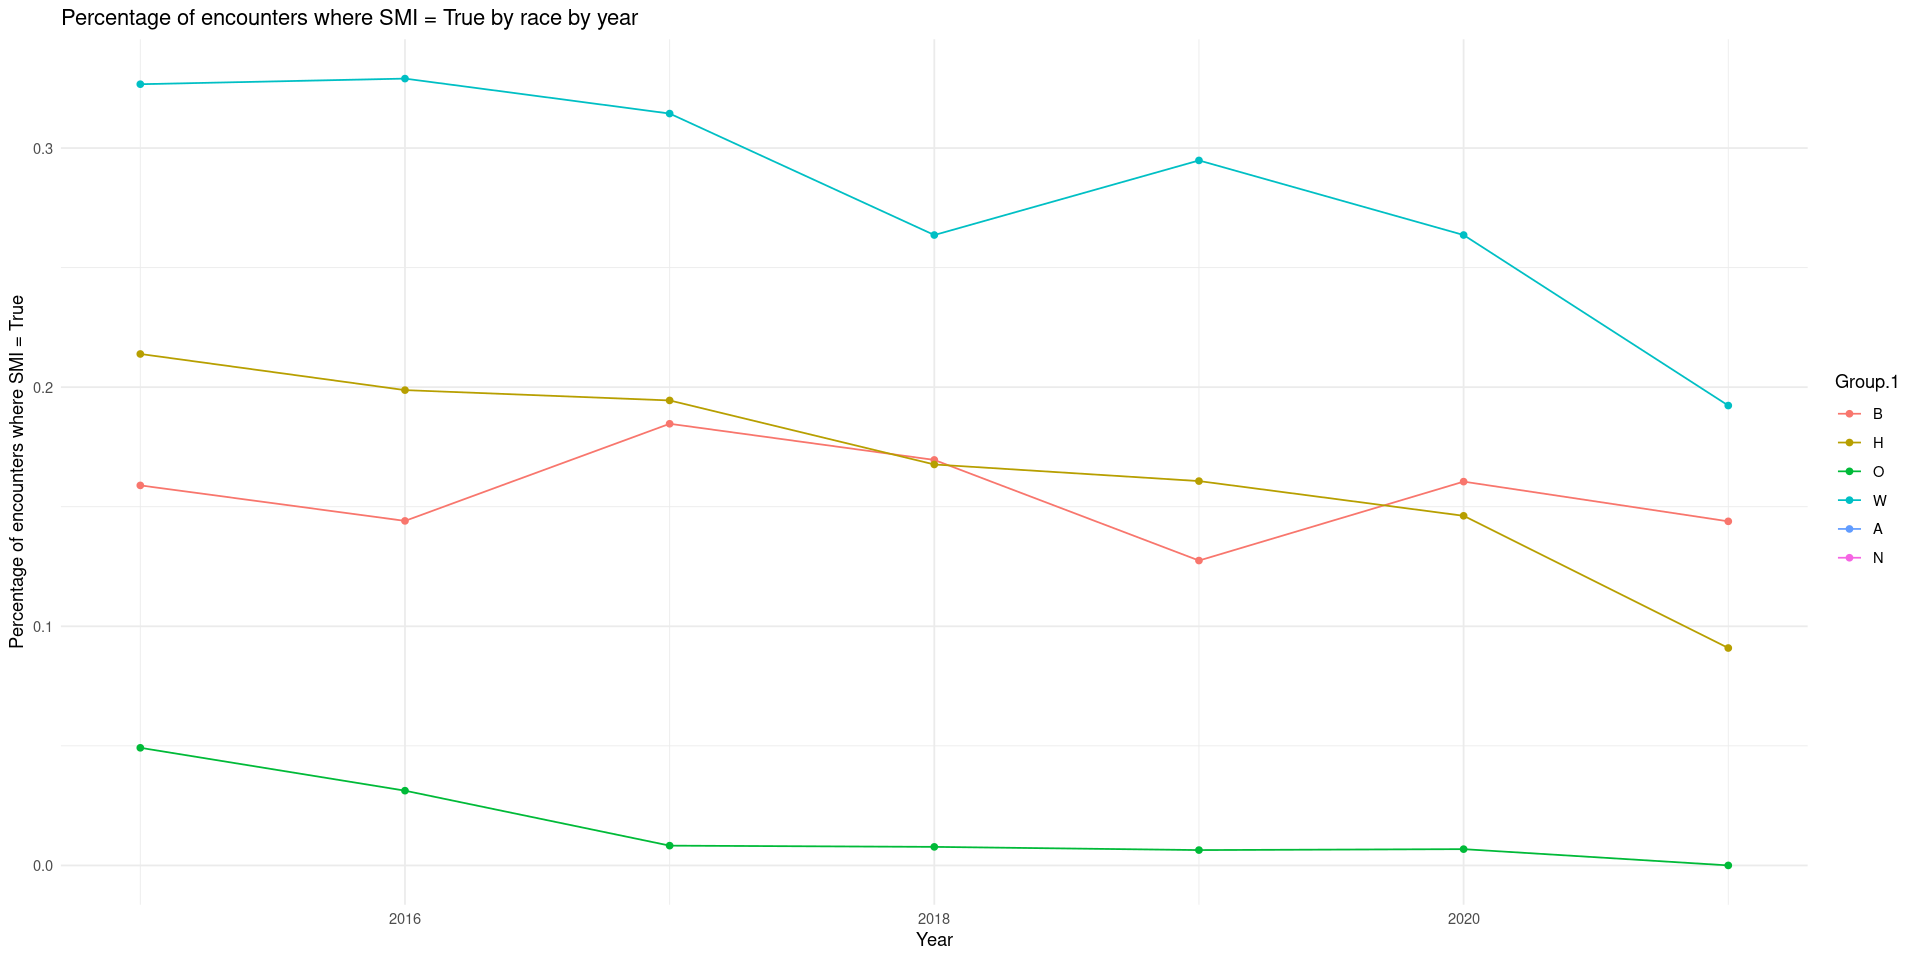

In [56]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(data=props_by_race_year,
       aes(x=Group.2, y=per, colour=Group.1)) +
       geom_line() + geom_point() + theme_minimal() +
       xlab("Year") +
       ylab("Percentage of encounters where SMI = True") +
       ggtitle("Percentage of encounters where SMI = True by race by year")

### General qns about data

"shot and Tasered" has 339 entries vs "shot" which has 6952 entries -> drop this feature? Not sure that it would affect our outcome

Convert age to categorical variable by binning?

Tranform the "armed" feature into Unarmed/gun/knife/vehicle/other? There are too many different values at the moment

Keep one of smha_exp_per_capita and smi_prevalance, depending on which one is more predictive

What are the dimensions along which we should consider random effects/random slopes?

Fit splines for anything?

How will we split the data? 

Any interactions that we should consider?

Use Poisson model?

How do we factor in the time dimension?
 1. Consider longitudinal by time
 2. Run separate regressions for 2015:16, 17:18, ... ? This can give us changing interpretations of different models (also extra residual analyses??)
 3. Take 2015-01-01 = day 0, and then convert dates to continuous feature that gets incorporated?

Add weights to the GLM model to handle imbalance in data (Weights <- ifelse(df$mental_illness == 1, 1/0.15, 1/0.85))

### Narrowing down list of features to consider

To drop: "id", "name", "city", "manner_of_death", "longitude", "latitude", "is_geo_coding_exact" (last 3 after pulling in weather info)

Continuous features:
1. age
2. smha_exp_per_capita
3. smi_prevalance

Categorical features:
1. armed
2. gender
3. race
4. state
5. threat_level
6. flee
7. body_camera
8. weather?